In [1]:
from itertools import product

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from src.models.layers import ECHConv2D

np.set_printoptions(precision=2, linewidth=150)


In [2]:
def tri(x):
    return np.where(np.abs(x) <= 1, np.where(x < 0, x + 1, 1 - x), 0)


def get_theta_in_degree(kernel_size):
    radius = (kernel_size - 1) // 2
    x_grid = np.arange(-radius, radius + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    theta = np.arctan2(y, x)
    return theta / np.pi * 180.0


def get_atoms(
    kernel_profiles,
    normalize=True,
    n_harmonics=4,
):
    kernel_size, _, n_profiles = kernel_profiles.shape
    radius = (kernel_size - 1) // 2
    x_grid = np.arange(-radius, radius + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    atoms = np.zeros(
        (
            kernel_size,
            kernel_size,
            n_harmonics,
            n_profiles,
        ),
        dtype=np.cdouble,
    )
    for k, i in product(range(n_harmonics), range(n_profiles)):
        atoms[:, :, k, i] = kernel_profiles[:, :, i] * np.exp(1j * k * theta)

    atoms[:, :, 1:, 0] = 0

    if normalize:
        norm = np.sqrt(np.sum(np.conj(atoms) * atoms, axis=(0, 1)))
        norm[norm == 0] = 1
        atoms = atoms / norm

    return atoms


def compute_spectrum(
    f,
    kernel_profiles,
    n_harmonics=4,
):
    atoms = get_atoms(
        kernel_profiles=kernel_profiles,
        normalize=True,
        n_harmonics=n_harmonics,
    )
    spectrum = np.zeros((n_harmonics))
    atoms_proj = np.sum(atoms, axis=-1)
    for n in range(n_harmonics):
        ch_proj = np.sum(f * np.conj(atoms_proj[..., n]))
        spectrum[n] = np.sqrt(np.abs(ch_proj * np.conj(ch_proj)))
    return spectrum


In [3]:
get_theta_in_degree(9)

array([[-135.  , -126.87, -116.57, -104.04,  -90.  ,  -75.96,  -63.43,  -53.13,  -45.  ],
       [-143.13, -135.  , -123.69, -108.43,  -90.  ,  -71.57,  -56.31,  -45.  ,  -36.87],
       [-153.43, -146.31, -135.  , -116.57,  -90.  ,  -63.43,  -45.  ,  -33.69,  -26.57],
       [-165.96, -161.57, -153.43, -135.  ,  -90.  ,  -45.  ,  -26.57,  -18.43,  -14.04],
       [ 180.  ,  180.  ,  180.  ,  180.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ],
       [ 165.96,  161.57,  153.43,  135.  ,   90.  ,   45.  ,   26.57,   18.43,   14.04],
       [ 153.43,  146.31,  135.  ,  116.57,   90.  ,   63.43,   45.  ,   33.69,   26.57],
       [ 143.13,  135.  ,  123.69,  108.43,   90.  ,   71.57,   56.31,   45.  ,   36.87],
       [ 135.  ,  126.87,  116.57,  104.04,   90.  ,   75.96,   63.43,   53.13,   45.  ]])

In [4]:
def compute_kernel_profiles(kernel_size):
    radius_max = kernel_size // 2
    kernel_profiles = np.zeros((kernel_size, kernel_size, radius_max))
    x_grid = np.arange(-radius_max, radius_max + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    r = np.sqrt(x**2 + y**2)
    for s in range(1, radius_max + 1):
        tmp = np.zeros_like(r)
        tmp[(r >= kernel_size * (s - 1) / (2 * radius_max))
            & (r < kernel_size * s / 2 / radius_max)] = 1
        kernel_profiles[:, :, s - 1] = tmp
    return kernel_profiles


def is_approx_equal(x, y, epsilon=1e-3):
    return np.abs(x - y) / (np.sqrt(np.abs(x) * np.abs(y)) + epsilon) < epsilon


def compute_kernel_profiles_complete(kernel_size):
    radius_max = kernel_size // 2
    n_profiles = radius_max**2 + radius_max + 1
    x_grid = np.arange(-radius_max, radius_max + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    theta = (np.arctan2(y, x) + 2 * np.pi) % (2 * np.pi)
    r = np.sqrt(x**2 + y**2)
    kernel_profiles = np.zeros((kernel_size, kernel_size, n_profiles))
    kernel_profiles[kernel_size // 2, kernel_size // 2, 0] = 1
    theta_shifts = [k * np.pi / 2 for k in range(4)]
    profile_counter = 1
    for i in range(1, radius_max + 1):
        n_pixels = 8 * i
        d_theta = theta[np.where(((np.abs(x) == i) | (np.abs(y) == i))
                                 & (r <= np.sqrt(2) * i))]
        d_theta.sort()
        d_theta = d_theta[:n_pixels // 4]
        for dt in d_theta:
            shifts = (dt + np.array(theta_shifts)) % (2 * np.pi)
            for t in shifts:
                kernel_profiles[is_approx_equal(theta, t) & ((np.abs(x) == i) |
                                                             (np.abs(y) == i))
                                & (r <= np.sqrt(2) * i), profile_counter] = 1
            profile_counter += 1

    return kernel_profiles


In [5]:
def get_circular_mask(kernel_size):
    radius_max = kernel_size // 2
    x_grid = np.arange(-radius_max, radius_max + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    r = np.sqrt(x**2 + y**2)
    return (r <= radius_max).astype(int)


def get_kernel_profiles_disk(kernel_size):
    radius_max = kernel_size // 2
    n_profiles = radius_max + 1
    x_grid = np.arange(-radius_max, radius_max + 1, 1)
    x, y = np.meshgrid(x_grid, x_grid)
    r = np.sqrt(x**2 + y**2)
    radial_profiles = np.zeros((kernel_size, kernel_size, n_profiles))
    for i in range(n_profiles):
        radial_profiles[(r <= i) & (r > i - 1), i] = 1
    return radial_profiles


In [6]:
kernel_profiles = get_kernel_profiles_disk(11)

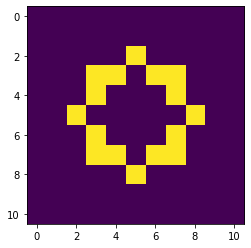

In [7]:
plt.imshow(kernel_profiles[:, :, 3])


In [8]:
# kernel_profiles = np.zeros((9, 9, 7))
# kernel_profiles[4, 4, 0] = 1
# kernel_profiles[([5, 4, 4, 3], [4, 3, 5, 4], [1, 1, 1, 1])] = 1
# kernel_profiles[([5, 5, 3, 3], [5, 3, 5, 3], [2, 2, 2, 2])] = 1
# kernel_profiles[([6, 2, 4, 4], [4, 4, 6, 2], [3, 3, 3, 3])] = 1
# kernel_profiles[([6, 2, 5, 3], [5, 3, 2, 6], [4, 4, 4, 4])] = 1
# kernel_profiles[([6, 2, 5, 3], [3, 5, 6, 2], [5, 5, 5, 5])] = 1
# kernel_profiles[([6, 6, 2, 2], [2, 6, 2, 6], [6, 6, 6, 6])] = 1


In [9]:
kernel_profiles[:,:,2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
composition_matrix= np.array([
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
]).T


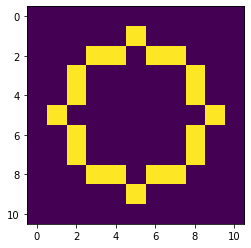

In [11]:
plt.imshow(kernel_profiles[..., 4])


In [12]:
kernel_profiles[:,:,4] * get_theta_in_degree(11)

array([[  -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ],
       [  -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,  -90.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ],
       [  -0.  ,   -0.  ,   -0.  , -123.69, -108.43,   -0.  ,  -71.57,  -56.31,   -0.  ,   -0.  ,   -0.  ],
       [  -0.  ,   -0.  , -146.31,   -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,  -33.69,   -0.  ,   -0.  ],
       [  -0.  ,   -0.  , -161.57,   -0.  ,   -0.  ,   -0.  ,   -0.  ,   -0.  ,  -18.43,   -0.  ,   -0.  ],
       [   0.  ,  180.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,  161.57,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,   18.43,    0.  ,    0.  ],
       [   0.  ,    0.  ,  146.31,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,   33.69,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  ,  123.69,  108.43,    0.  ,   71.57,   56.31,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,   

In [13]:
kernel_profiles[:, :, 0]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
max_degree = 5
radius_window = 2
shs = get_atoms(
    kernel_profiles,
    normalize=True,
    n_harmonics=4
)
shs = np.sum(shs, axis=-1)
# shs = get_chs(kernel_size=kernel_size, degrees=max_degree)

In [15]:
shs.shape

(11, 11, 4)

In [16]:
dot_prod = np.sum((shs[:, :, 1]) * np.conj(shs[:, :, 3]))
np.abs(dot_prod)


2.618455766672135e-16

In [17]:
dot_prod_mat = np.zeros((shs.shape[-1], shs.shape[-1]))
for k, kp in product(range(shs.shape[-1]),range(shs.shape[-1])):
    dot_prod_mat[k, kp] = np.abs(np.sum((shs[:, :, k]) * np.conj(shs[:, :, kp])))

dot_prod_mat

array([[6.00e+00, 1.11e-16, 1.86e-16, 5.10e-16],
       [1.11e-16, 5.00e+00, 2.22e-16, 2.62e-16],
       [1.86e-16, 2.22e-16, 5.00e+00, 2.22e-16],
       [5.10e-16, 2.62e-16, 2.22e-16, 5.00e+00]])

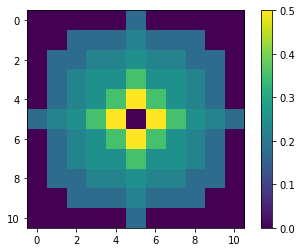

In [18]:
plt.imshow(np.abs(shs[..., 3]))
plt.colorbar()

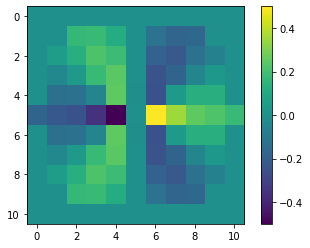

In [19]:
plt.imshow(np.real(shs[..., 3]))
plt.colorbar()

In [20]:
factor = np.zeros((shs.shape[-1]), dtype=np.cdouble)
factor[1] = 1
factor[0] = 1
factor[2] = 1
factor[3] = np.exp(1j * 2 * np.pi / 3)
# factor[4] = np.exp(1j * 2 * np.pi / 3)
# factor[5] = np.exp(1j * 2 * np.pi / 3)

phi1 = 0
phi2 = np.pi * 0.25
rotation_factor1 = np.array([np.exp(1j * k * phi1) for k in range(shs.shape[-1])])
rotation_factor2 = np.array([np.exp(1j * k * phi2) for k in range(shs.shape[-1])])


In [21]:
rotation_factor1

array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [22]:
mask = get_circular_mask(shs.shape[0])
f = (np.sum(shs * factor * rotation_factor1, axis=-1)) 
f_rotated = (np.sum(shs * factor * rotation_factor2, axis=-1))
f_real = np.real(f) * mask
f_real_rotated = rotate(f_real, phi2*180/np.pi, reshape=False)

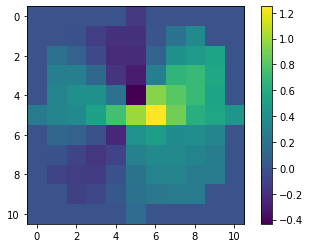

In [23]:
plt.imshow(np.real(f))
plt.colorbar()

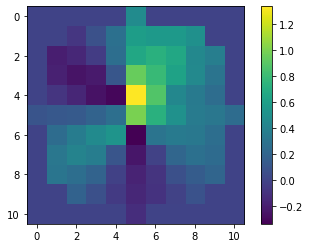

In [24]:
plt.imshow(np.real(f_rotated))
plt.colorbar()

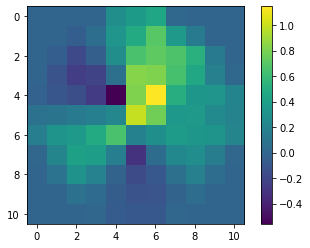

In [25]:
plt.imshow(f_real_rotated)
plt.colorbar()

In [26]:
compute_spectrum(f,
                 kernel_profiles,
                 n_harmonics=8,
                 )


array([6.  , 5.  , 5.  , 5.  , 0.75, 0.75, 0.75, 0.75])

In [27]:
compute_spectrum(f_rotated,
                 kernel_profiles,
                 n_harmonics=8,
                 )


array([6.  , 5.  , 5.  , 5.  , 0.75, 0.75, 0.75, 0.75])

In [28]:
compute_spectrum(f_real,
                 kernel_profiles,
                 n_harmonics=8,
                 )


array([6.  , 2.34, 2.87, 2.34, 0.75, 0.87, 1.37, 0.87])

In [29]:
compute_spectrum(f_real_rotated,
                 kernel_profiles,
                 n_harmonics=8,
                 )


array([5.75, 2.26, 2.22, 2.12, 0.67, 0.75, 0.77, 0.87])

In [33]:
x = np.random.uniform(size=(11,11)) 
x_rotated = rotate(x, 90, reshape=False)

In [34]:
f.shape

(11, 11)

In [35]:
compute_spectrum(x,
                 kernel_profiles,
                 n_harmonics=8,
                 )

array([9.27, 0.47, 0.73, 0.43, 0.33, 0.86, 1.18, 0.42])

In [36]:
compute_spectrum(x_rotated,
                 kernel_profiles,
                 n_harmonics=8,
                 )

array([9.27, 0.47, 0.73, 0.43, 0.33, 0.86, 1.18, 0.42])